<a href="https://colab.research.google.com/github/RoyRin/multi-party-learning/blob/master/code/notebooks/NN_memorization_experiments_v2_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)
BASE_DIR="/content/drive/MyDrive/Research/Privacy/experiments/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
BASE_DIR="/content/drive/MyDrive/Research/Privacy/experiments/"
PROJECT_PATH = os.path.join(BASE_DIR, "GIT_neural_nets_memorization")


GIT_TOKEN_path = os.path.join(BASE_DIR, "royrin_GIT_TOKEN.txt")

GIT_USERNAME = "RoyRin"
GIT_REPOSITORY = "neural_nets_memorization"

!set -x
!rm -rf "{PROJECT_PATH}"
!mkdir "{PROJECT_PATH}"
!git clone https://"`cat {GIT_TOKEN_path}`"@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git "{PROJECT_PATH}"

!pip install -r "{PROJECT_PATH}/requirements.txt"

In [3]:
%%capture
!pip install opacus


In [4]:
!pip list | grep "opacus"

opacus                        1.0.1


In [5]:
# import custom imports 
import pathlib

if not os.path.exists(PROJECT_PATH):
    cwd = pathlib.Path().resolve()
    PROJECT_PATH = cwd.parent.parent 

print(PROJECT_PATH)
code_path = os.path.join(PROJECT_PATH, "code")

from importlib.machinery import SourceFileLoader

#module_names = [str(p.parts[-1]) for p in Path(os.path.join(PROJECT_PATH, "code")).glob("*.py")  if p.parts[-1] != "__init__.py"]
module_names = [ 'params',  'utils',  'dataset_management',
                'unbalanced_datasets', 'privacy', 'model_training', 'models', 
                'pate',  'memorization_experiment',]

modules = []
for module_name in module_names:
  modules.append(SourceFileLoader(module_name, os.path.join(PROJECT_PATH, 'code', module_name +".py" )).load_module())

import params
import utils
import dataset_management
import unbalanced_datasets
import  privacy
import  model_training
import  models
import  pate
import  memorization_experiment

/content/drive/MyDrive/Research/Privacy/experiments/GIT_neural_nets_memorization


In [6]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Subset



In [7]:
(trainset, testset), (trainloader,
                      testloader) = dataset_management.load_MNIST_datasets_and_loaders()
num_classes =len(trainset.classes)
device = params.get_default_device()

## random memorization experiment


In [8]:
# CNN Model
basemodel_name = "FCN"
basemodel = Model = models.FCN

In [9]:
import numpy as np
import matplotlib.pyplot as plt
def plot(x,y, title = ""):
  size = (10, 12)
  plt.figure(figsize=size)
  plt.title("Studying memorization: "+ title)
  plt.plot(x,y)
  plt.show()


from scipy.stats import norm
N = 100
y_range = 3. 
midpoint = int(N/2)

#
# original data 
x = np.arange(N)
y = np.random.randn(N) * y_range
std = np.std(y)
outlier = std * 8 

# replace midpoint
x = np.arange(N)
y = np.random.randn(N) * y_range
y[midpoint] = outlier


# replace endpoint
x = np.arange(N)
y = np.random.randn(N) * y_range
y[-1] = outlier


mean,std=norm.fit(y)
mean
#std
# todo: train a model on the 3 cases, and look at the memorization value 
# the idea that I have is that the curvature is much smaller if it is the end point, rather than the midpoint
# so it is easier to learn, and a lower memorization value.

0.2322963252722504

In [10]:
# -*- coding: utf-8 -*-
import torch
import math


# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)
# Prepare the input tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3])

xx = x.unsqueeze(-1).pow(p)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(len(p), 10),
    torch.nn.Linear(10, 1),
    torch.nn.Flatten(0, 1)
)
model = torch.nn.Sequential(
    torch.nn.Linear(len(p), 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
verbose= False
for t in range(len(xx)):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(xx)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if verbose and t % 100 == 99:
        print(t, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## todo : 
# compute distance from model(x) to y
## todo: evaluate model(x)

linear_layer = model[0]
#print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x ') # + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')
print(f"loss {loss}")

loss 8.917607307434082


## regular scheduled programming

In [11]:
from opacus.validators import ModuleValidator
import datetime
from opacus.utils.batch_memory_manager import BatchMemoryManager
MAX_PHYSICAL_BATCH_SIZE = 128 
from opacus.grad_sample import GradSampleModule
import numpy as np

# Memorization experiment


https://arxiv.org/pdf/2008.03703.pdf 
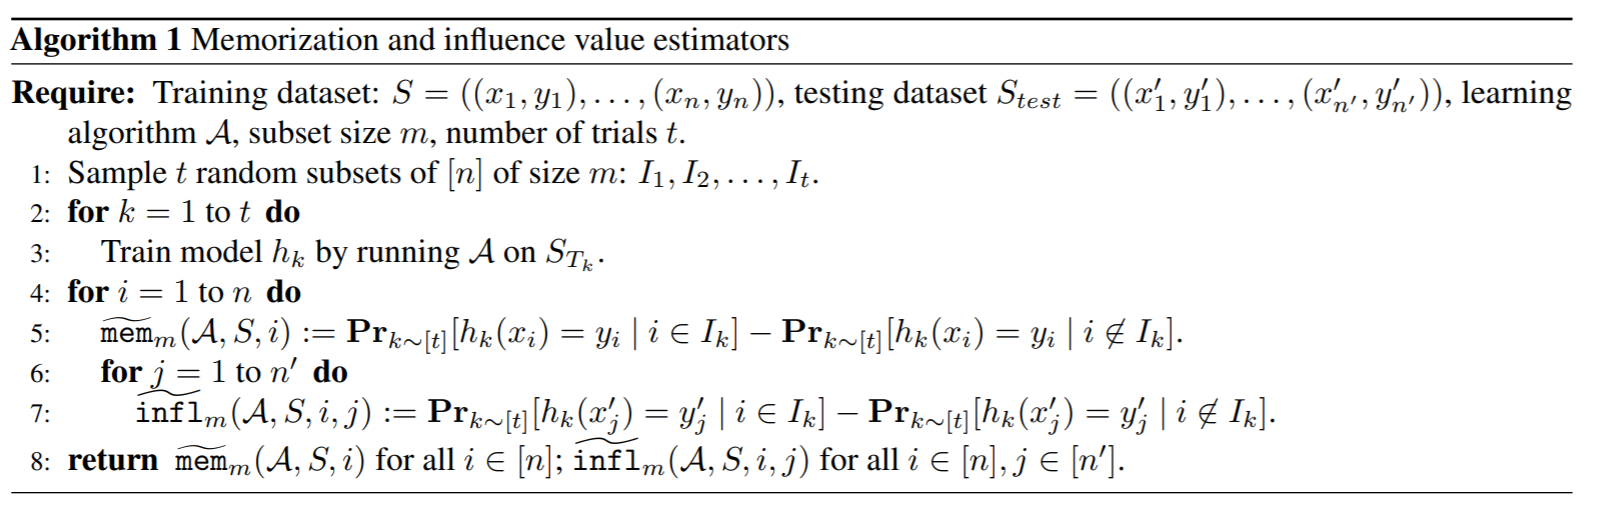

set up the memorization experiment indices for the datasets

In [12]:
# TODO : now remap this to also include epochs
# todo: set up computing the confidences from the models. 

def dataset_from_indices(mask, dataset):
  indices = mask.nonzero()[0]
  if not (isinstance(indices, np.ndarray)):
    raise Exception(f"Indices are not numpy array: {type(indices)}")
  return Subset(dataset, indices)

def set_up_memorization_experiment_dataset_masks(filepath= None, N = 60000, m_ratio = 0.8, trials = 2000, overwrite = False ):
  """ Create a numpy matrix of 1's and 0's of the form
    [0 0 1 1 0 1 0]
    [1 1 0 0 0 1 0]
    [0 0 1 1 0 0 1]
  each row represents the points to include in the model for that experiment
  each row has m_ratio* N 1's, randomly shuffled. 

  """
  if os.path.exists(filepath) and not overwrite: 
      mem_exp_masks = utils.load_np_from_filename(filepath)
      if mem_exp_masks is not None:
          return mem_exp_masks

  m = int(m_ratio * N)
  base_mask = np.pad(np.ones(m),(0, N-m))
  mem_exp_masks = np.zeros((trials, N), dtype = "bool") # indices is a matrix of the masks for each trial
  for trial_ind in range(trials):
    mask = base_mask.copy()
    np.random.shuffle(mask)
    mem_exp_masks[trial_ind] = mask
  #return mem_exp_masks
  if filepath:
    utils.save_np_to_filename(filepath, mem_exp_masks, overwrite=overwrite)
  return mem_exp_masks



In [13]:
def CNN_model_factory(device = params.get_default_device()):
  m = models.CNN(num_classes=10)
  m.to(device)
  return m 

def run_single_experiment( *, model, dataloader,memorization_dataloader, 
                          model_confidences, save_path, 
                          tensorboard_path, model_name = "CNN", 
                          epochs =5, overwrite = False):
  # set up file path and sttuff
  # where we are at. beep boop baap
  
  print(f"starting experiment on {model_name}")
  
  res = model_training.do_it_all(model=model,
            model_name=model_name,
            criterion=params.criterion,
            save_path=save_path,
            tensorboard_path=tensorboard_path,
            eps= None, #eps,
            delta=None, #delta,
            trainloader=dataloader,
            testloader=testloader,
            device=device,
            epochs=epochs,
            max_grad_norm=params.MAX_GRAD_NORM,
            dp_prototypicalness_labels_list_of_dicts=
            None,
            model_confidences= model_confidences,
            memorization_eval_loader = trainloader,
            overwrite=overwrite)
          
  return res, model_confidences

def generate_save_paths(base_save, model_name):
    save_path = os.path.join(base_save, model_name +".pth")
    tensorboard_path  = base_save
    return save_path, tensorboard_path

def round_name_setup(memorization_ASSETS_PATH, model_name):
    """get the paths for tensorboard and model saving (make dir if not yet exist)
    Returns:
        tensorboard_path, save_path
    """
    os.makedirs(os.path.dirname(memorization_ASSETS_PATH), exist_ok=True)  
    tensorboard_path = memorization_ASSETS_PATH
    save_path = os.path.join(memorization_ASSETS_PATH, model_name+ ".pth")
    return tensorboard_path, save_path



def run_all_experiments(mem_experiment_masks, confidences, 
                        memorization_experiments_meta_filepath, 
                        base_save, dataset, memorization_dataloader,
                        epochs = 5, basemodel_name = "CNN", overwrite = False ):
    """ run memorization experiments """
    memorization_experiments_meta = {} # todo :read this to and from memory
    if os.path.exists(memorization_experiments_meta_filepath):
      memorization_experiments_meta = utils.open_yaml( memorization_experiments_meta_filepath)

    for model_ind, model_mask in enumerate(mem_experiment_masks):
        torch.cuda.empty_cache()
        model_name = f"{basemodel_name}_{model_ind}"
        print(f"working on :{model_name}")
        # get the datasets
        
        subset = dataset_from_indices(model_mask, dataset )
        subset_dataloader = dataset_management.load_dataloader(subset)

        # run a single memorizatoin experiment        
        
        save_path, tensorboard_path = generate_save_paths(base_save, model_name)
        
        res, model_confidences = run_single_experiment(model = CNN_model_factory(device = device),
                                                       memorization_dataloader = memorization_dataloader, 
                                                       dataloader = subset_dataloader, 
                                                       model_confidences = confidences[model_ind], 
                                                       save_path = save_path, 
                                                       tensorboard_path = tensorboard_path, 
                                                       model_name = model_name, 
                                                       epochs =epochs, 
                                                       overwrite = overwrite)
        ## save data
        model_mask_indices = model_mask.nonzero()[0]
        res["dataset_indices"] =  model_mask_indices.tolist()
        memorization_experiments_meta[model_name] = res # update meta data
        confidences[model_ind] = model_confidences # update confidences
        
        # save confidences to 
        utils.save_np_to_filename(confidences_filepath, confidences, overwrite = True)
        utils.write_yaml(memorization_experiments_meta_filepath, memorization_experiments_meta)

    return model_storage, dp_prototypicalness_labels_list_of_dicts


### Set up for memorization experiments

In [14]:
# SET UP

confidences = None #np.zeros((model_counts, epochs, N))
mem_experiment_masks = None 
ASSETS_PATH = os.path.join(BASE_DIR, "assets","MNIST", "memorization")
os.makedirs(os.path.dirname(ASSETS_PATH), exist_ok=True)

round_name = "round_0.1.1"
round_ASSETS_PATH = os.path.join(ASSETS_PATH, round_name)
os.makedirs(round_ASSETS_PATH, exist_ok=True)
torch.cuda.empty_cache()
    

base_save= round_ASSETS_PATH
mem_exp_masks_filepath = os.path.join(round_ASSETS_PATH, "memorization_masks.npy")
confidences_filepath = os.path.join(round_ASSETS_PATH, "confidences.npy")
memorization_experiments_meta_filepath= os.path.join(round_ASSETS_PATH, "memorization_experiments_meta.yaml")

epochs = 5
model_counts = 2000

dataset = trainset

N = len(trainset.targets)


if os.path.exists(confidences_filepath) and confidences is not None:
    confidences = utils.load_np_from_filename(confidences_filepath)
else:
  confidences = np.zeros((model_counts, epochs, N), dtype = "float32") # 2000 * 5 * 60000
  utils.save_np_to_filename(confidences_filepath, confidences) # save the confidences to the filepath (if not yet saved)

mem_experiment_masks = set_up_memorization_experiment_dataset_masks(filepath= mem_exp_masks_filepath, 
                                                                        N = len(dataset), m_ratio = 0.8, trials = model_counts, 
                                                                        overwrite = False )

file already exists, ignoring


In [15]:
torch.cuda.empty_cache()

In [16]:
ds = dataset_from_indices(mem_experiment_masks[0], trainset)
dl = dataset_management.load_dataloader(ds)


In [17]:
"""run_single_experiment( *, model, dataloader, 
                          model_confidences, save_path, 
                          tensorboard_path, model_name = "CNN", 
                          epochs =5, overwrite = False)
"""
test_single_experiment= False
if test_single_experiment:
    run_single_experiment( model = CNN_model_factory(device = device), dataloader = dl, 
                      memorization_dataloader = trainloader, 
                      model_confidences = confidences[0], 
                      save_path = "save_path", tensorboard_path= "tensorboard_path", model_name = "model_name", epochs =epochs, overwrite = False)

In [18]:
a = np.zeros(10, dtype = "float32")
print(a.size * a.itemsize)
a = np.zeros(10)
print(a.size * a.itemsize)

40
80


In [26]:
confidences[0]

array([[0.47707567, 0.44953397, 0.24549761, ..., 0.3143184 , 0.20039317,
        0.31352678],
       [0.45862815, 0.48940971, 0.24364449, ..., 0.3339285 , 0.19999523,
        0.33141512],
       [0.45000517, 0.48045897, 0.24688414, ..., 0.3326265 , 0.19985169,
        0.32362452],
       [0.4510264 , 0.46833366, 0.24923594, ..., 0.33651915, 0.1996686 ,
        0.330892  ],
       [0.44003978, 0.4837275 , 0.2475655 , ..., 0.32789412, 0.19975743,
        0.32381433]], dtype=float32)

In [ ]:
%%time 
if mem_experiment_masks is None and os.path.exists(mem_exp_masks_filepath):
    mem_experiment_masks = utils.load_np_from_filename(mem_exp_masks_filepath)

if confidences is None and os.path.exists(confidences_filepath):
  confidences = utils.load_np_from_filename(confidences_filepath) # read from filepath


run_all_experiments( memorization_dataloader = trainloader, mem_experiment_masks = mem_experiment_masks, confidences = confidences, 
                    memorization_experiments_meta_filepath=memorization_experiments_meta_filepath, 
                    base_save=base_save, dataset= dataset, basemodel_name = "CNN", epochs = epochs, overwrite = False)


working on :CNN_0
starting experiment on CNN_0
epsilon - None
path /content/drive/MyDrive/Research/Privacy/experiments/assets/MNIST/memorization/round_0.1.1/CNN_0.pth already saved to. SKIPPING.
working on :CNN_1
starting experiment on CNN_1
epsilon - None
path /content/drive/MyDrive/Research/Privacy/experiments/assets/MNIST/memorization/round_0.1.1/CNN_1.pth already saved to. SKIPPING.
working on :CNN_2
starting experiment on CNN_2
epsilon - None
path /content/drive/MyDrive/Research/Privacy/experiments/assets/MNIST/memorization/round_0.1.1/CNN_2.pth already saved to. SKIPPING.
working on :CNN_3
starting experiment on CNN_3
epsilon - None
path /content/drive/MyDrive/Research/Privacy/experiments/assets/MNIST/memorization/round_0.1.1/CNN_3.pth already saved to. SKIPPING.
working on :CNN_4
starting experiment on CNN_4
epsilon - None
path /content/drive/MyDrive/Research/Privacy/experiments/assets/MNIST/memorization/round_0.1.1/CNN_4.pth already saved to. SKIPPING.
working on :CNN_5
startin

In [ ]:
indices

In [ ]:
memorization_estimator_exp = False
if memorization_estimator_exp:
  # todo : save indices, and don't misplace it
  influence = np.zeros((N,N))
  conf = np.zeros((m,N)) 
  for i in range(N):
    # pick a model A (index A) that is trained with i
    # pick a model B  (index B) that is not trained with i
    for j in range(N):
      influence[i][j] = conf[A][j] - conf[B][j]

  influence


In [ ]:
m = utils.to_device(m, "cpu")

In [ ]:
%%time

#conf = compute_train_correct_accuracies(m, trainloader, device)


In [ ]:
## TODO: train model and look at different condiences 
c = 2
for i in range(2):
    m = models.CNN(num_classes=10)
    res = model_training.do_it_all(
                    model=m,
                    model_name="butt",
                    criterion=params.criterion,
                    save_path=f"arg_{c}_{i}.pth",
                    tensorboard_path="arg",
                    trainloader=trainloader,
                    testloader=testloader,
                    device=device,
                    epochs=3,
                    max_grad_norm=params.MAX_GRAD_NORM,
                    overwrite=False,
                    model_confidences= model_confidences[i])

In [ ]:
model_confidences

In [ ]:
trainloader.dataset.targets

In [ ]:
len(trainloader.dataset)

In [ ]:
if model_confidences[0] is not None:
  print(1)

In [ ]:
55479 / 60000

In [ ]:
raise Exception

In [ ]:
%%time
a_train = compute_train_correct_accuracies(m, trainloader, device)
a_val = compute_train_correct_accuracies(m, testloader, device)

print(a_train, a_val)


In [ ]:
def compute_train_correct_accuracies(model, train_loader, device):
    ''' Computes the accuracy of the model on the training set
    and compute predictoin confidence for each datapoint  
    '''
    total = 0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            softmax = torch.nn.functional.softmax(output[0], dim=0)
            conf = softmax[target]
            #conf, pred = torch.max(output, 1)
            total += target.size(0)
            correct += (pred == target).sum().item()
    return correct / total

def compute_train_correct_accuracies(model, train_loader, device):
    # compute the confidences matrix
    confidences = np.zeros(len(trainset.targets), dtype = "float32"))
    with torch.no_grad():
        for i, (data, targets) in enumerate(trainloader):
            data, targets = data.to(device), targets.to(device)
            output = model(data) # make prediction
            softmax = torch.nn.functional.softmax(output, dim=0)
            w = len(targets)
            confs = softmax[np.arange(len(softmax)), targets]
            confidences[w* i: w*(i+1) ] = utils.to_device(confs, "cpu")
    return confidences
    
m = models.FCN(num_classes = 10)
m = utils.to_device(m, device)
trainloader 

In [ ]:
confidences

In [ ]:
for i in target:
  print(i)

In [ ]:
output.shape
softmax = torch.nn.functional.softmax(output, dim=0)
print(softmax.shape)#[target]
print(target.shape)
print(softmax[:,target].shape)


In [ ]:
softmax[np.arange(len(softmax)), target]

In [ ]:
softmax[:,target].shape

In [ ]:
np.arange(3,)

In [ ]:
# compute confidences 
# todo : save and load confidences
# todo: change the do-it to return confidences


In [ ]:
softmax[0][1]

## TODO:
1. create a plan for which models to train
2. create a map that maps models to indicies
3. create a map that maps indicies to models that are trained on them (it should be possible to just do (total models) - (models that contain an index).

4. 


process 1 - pick which models to train
process 2 - pick which models to evaluate
- we should do them together.

In [ ]:
def get_dataset_without_index(dataset, drop_ind):
    """
    Given a dataset, return a dataset missing a particular index
    """
    if drop_ind < 0 or drop_ind >= len(dataset):
      return dataset 
    indices_mask =  np.ones(len(dataset), dtype=bool)
    indices_mask[drop_ind] = False
    indices = np.arange(len(dataset))[indices_mask]
    return Subset(dataset, indices)

def probability_of_label( model, img, label):
  """ returns the probability of the model predicting a particular label for a particular image
  """
  img = utils.to_device(img, device)
  model = utils.to_device(model, device)
  img.unsqueeze_(0)
  with torch.no_grad():
      yb = model(img)
  softmax = torch.nn.functional.softmax(yb[0], dim=0)
  confidence = softmax[label]
  return confidence.item()
  

def round_name_setup(memorization_ASSETS_PATH, model_name):
    """get the paths for tensorboard and model saving (make dir if not yet exist)
    Returns:
        tensorboard_path, save_path
    """
    base_save = memorization_ASSETS_PATH
    os.makedirs(os.path.dirname(base_save), exist_ok=True)  
    tensorboard_path = base_save
    save_path = os.path.join(base_save, model_name+ ".pth")
    return tensorboard_path, save_path




def train_memorization(missing_index, epochs = 6):
    """
    train a model on a dataset without a given point

    """
    model = models.CNN(num_classes = 10)
    dataset = trainset
    in_range = missing_index >= 0 and missing_index < len(trainset)
    if in_range:
        dataset = get_dataset_without_index(dataset, missing_index)
        model_name = f"CNN_missing_{missing_index}"
    else:
        model_name = "CNN_ordinary"
    
    dataloader = dataset_management.load_dataloader(dataset)
    tensorboard_path, save_path = round_name_setup(memorization_ASSETS_PATH, model_name)
    print(f"save path is {save_path}")
    res = model_training.do_it_all(
                model=model,
                model_name=model_name,
                criterion=params.criterion,
                save_path=save_path,
                tensorboard_path=tensorboard_path,
                trainloader=dataloader,
                testloader=testloader,
                device=device,
                epochs=epochs,
                max_grad_norm=params.MAX_GRAD_NORM,
                overwrite=False)
    if in_range:
      img, target = dataset[missing_index]
      prob_of_correct_label = probability_of_label(model, img, target)
      res["probability_of_correct_label"] = prob_of_correct_label
      res["missing_index"] = missing_index
      res["correct_label"] = target
    return res
  

In [ ]:
round_name = "0.1.0"
memorization_ASSETS_PATH = os.path.join(ASSETS_PATH, "memorization", round_name)
memorization_ASSETS_PATH


In [ ]:
from pathlib import Path
import yaml
def open_yaml_unsafe(filename):
    """ return the contents of yaml as a dictionary """
    path = Path(filename)
    if not path.is_file():
        return None
    try:
        with open(path, "r") as infile:
            return yaml.load(infile)
    except Exception as e:
        print(e)
    return {}


In [ ]:
dataset = trainset
# maps from { idx-of-class : np.array(indices) }
class_to_idx = {class_idx: np.arange(len(dataset))[dataset.targets == class_idx] for class_idx in range(len(dataset.classes))}
epochs = 5

memorization_experiment_results = {}
memorization_experiment_results_yaml = os.path.join(memorization_ASSETS_PATH, "memorization.yaml")

if os.path.exists(memorization_experiment_results_yaml):
    memorization_experiment_results = open_yaml_unsafe( memorization_experiment_results_yaml)
print(f"len of memorization_experiment_results is {len(memorization_experiment_results)}")
res = train_memorization(-1, epochs = epochs)
memorization_experiment_results["ordinary"] = res

for i in range(len(trainset.targets)):
    print(f"index is {i}")
    #class_idx = i % len(dataset.classes)
    #index = np.random.choice(class_to_idx[class_idx])
    index = i # remove randomness here
    if index in memorization_experiment_results:
      continue
    res = train_memorization(index, epochs = epochs)
    print(f"Result for {index} : {res}")
    print(f"Probability of correct label : {res.get('probability_of_correct_label')}")
    memorization_experiment_results[index] = res
    utils.write_yaml(memorization_experiment_results_yaml,
                      memorization_experiment_results)





In [ ]:
hours = 10
minutes = hours * 60
epochs_trained = 5
seconds_per_epoch = 16
minutes_per_training = epochs_trained * seconds_per_epoch /60
print(f"number of memorization values we can measure the memoriztion of, in 10 hours: {(minutes)/(minutes_per_training)}") 

In [ ]:
# TODO:


## TODO 
1. figure out how to monitor probability of correctness during training
2. Actually do the memorization estimator

In [ ]:
## back of the envelope math:

# to train a model, epoch ~ 24 seconds. 13 epochs = 5 minutes per model.
# to test 1 memorization = 10 minutes per point.
# classes = 10.  10
